## ADDI project

This project is dedicated to the cancer segmentation task. It will be splitted in 3 major parts:


*   Data preprocessing
*   Constructing models
*   Benchmarking

During the project i am going to construct several deep learning models and apply distinct loss functions to reveal the most effective one.







---


1. Downloading the dataset: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>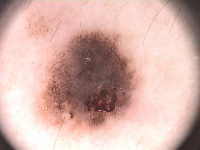</td><td>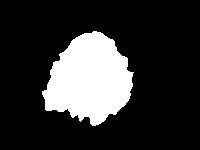</td></tr></table>

2. Unzip .rar file.

These are photos of two types of **skin lesions:** melanoma and moles.
In this task, we will not be engaged in their classification, but will **segment** them.

In [1]:
!wget -c https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar

--2023-04-20 13:14:13--  https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/8lqrloi0mxj2acu/PH2Dataset.rar [following]
--2023-04-20 13:14:14--  https://www.dropbox.com/s/raw/8lqrloi0mxj2acu/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucec9a4e272101419aab0896a40c.dl.dropboxusercontent.com/cd/0/inline/B6gkE0wGZMaAayBQxNKw0z5Nd4Oe2F5xiRxYAJLrUJMGaVU7DyDcuu5nwI5mQzsN2rqVu1rtmSuUzuGQmYryuyd2HjAmue4_Vd4385mDFnQ3oPwbqPbrfzcm4yFjrP6TZS07ydcu_k7bOw7Q3TopAsfvoz88S3v7PIQmAgKr2l9a3A/file# [following]
--2023-04-20 13:14:14--  https://ucec9a4e272101419aab0896a40c.dl.dropboxusercontent.com/cd/0/inline/B6gkE0wGZMaAayBQxNKw0z5Nd4Oe2F5xiRxYAJLrUJMGaVU7DyDcuu5nwI5mQzsN2rqVu1rtmS

In [2]:
!ls

PH2Dataset.rar	sample_data


In [3]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Dataset's structure is as following:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Here `X.bmp` — the image to segment, `X_lesion.bmp` is the result of segmentation.

To load a dataset, you can use skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [4]:
import os
import numpy as np
import pandas as pd
from skimage import io
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as tfs
import torchvision.models
from torchsummary import summary
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from IPython.display import clear_output
from tqdm.notebook import tqdm
import pickle
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

In [5]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

The images have different sizes. Let's change their size to $256\times 256$ pixels. To change the size of images, you can use [`sk image.transform.resize()`](http://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
This function also automatically normalizes images in the range of $[0,1]$.

In [6]:
transform = A.Compose([
    A.Resize(256, 256)
])

class CustomDataSet(Dataset):
    def __init__(self, main_dir, transform):
        self.transform = transform
        self.samples = []
        self.labels = []
        for root, dirs, files in os.walk(main_dir):
            if root.endswith('_Dermoscopic_Image'):
                self.samples.append(os.path.join(root, files[0]))
            if root.endswith('_lesion'):
                self.labels.append(os.path.join(root, files[0]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image = cv2.imread(self.samples[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = cv2.imread(self.labels[idx], cv2.IMREAD_GRAYSCALE)
        transformed = self.transform(image=image, mask=label)
        tensor_image = transformed['image'].transpose(2, 0, 1)
        label_image = transformed['mask'][np.newaxis, :]
        tensor_image = torch.FloatTensor(tensor_image) / 255
        label_image = torch.FloatTensor(label_image) / 255
        return tensor_image, label_image

In [7]:
root = 'PH2Dataset'
batch_size = 16
dermoscopic_dataset = CustomDataSet(os.path.join(root, 'PH2 Dataset images'), transform=transform)

idx = np.random.choice(len(dermoscopic_dataset), len(dermoscopic_dataset), False)
train_idx, valid_idx, test_idx = np.split(idx, [100, 150])
# train_idx, test_idx = np.split(idx, [150])

dataset_train = Subset(dermoscopic_dataset, train_idx)
dataset_valid = Subset(dermoscopic_dataset, valid_idx)
dataset_test  = Subset(dermoscopic_dataset, test_idx)

dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_valid = DataLoader(dataset_valid, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

In [8]:
len(dataset_train)

100

In [9]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [10]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [11]:
len(lesions)

200

To make sure that everything is correct, we will draw several images

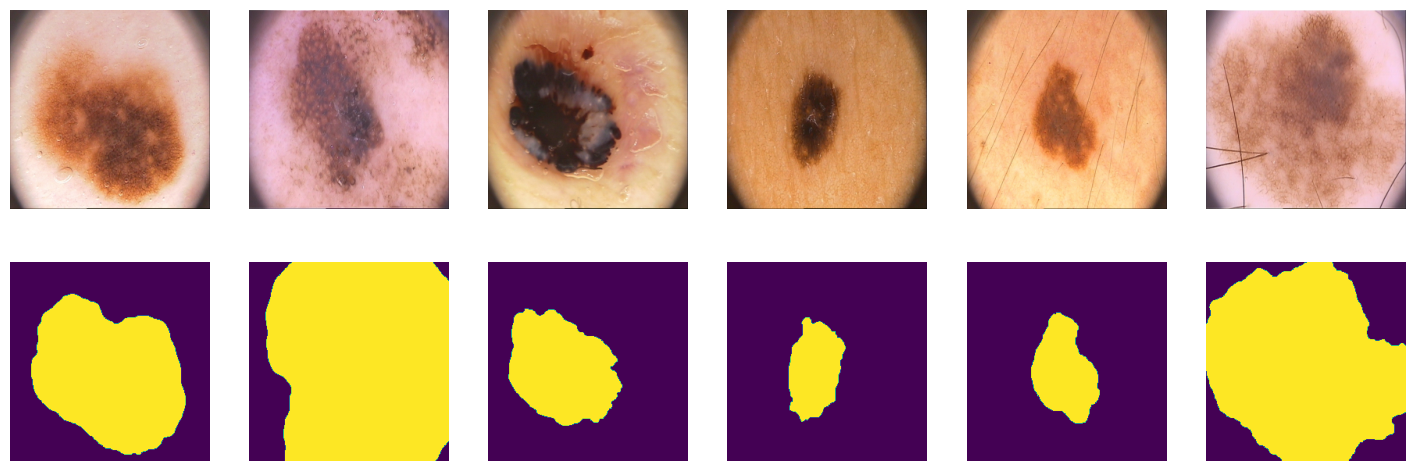

In [12]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Let's divide our 200 images into 100/50/50
for training, validation and test, respectively

In [13]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [14]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [15]:
from torch.utils.data import DataLoader
batch_size = 16
# data_tr = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
# data_val = DataLoader(dataset_valid, batch_size=batch_size, shuffle=True)
# data_ts = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

In [16]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Implementation of various architectures:
Your task will be to write several neural network architectures to solve the problem of semantic segmentation. Compare them by quality on the test and try out different loss functions for them.

-----------------------------------------------------------------------------------------

# SegNet

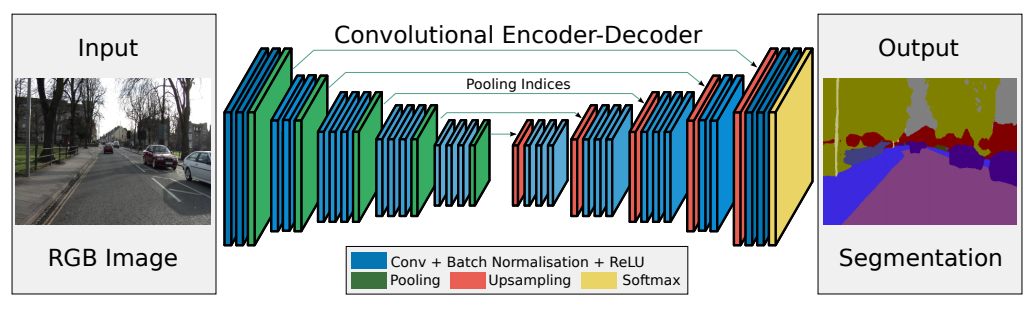

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [18]:
class SegNet(nn.Module):
    def _conv_layer(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    
    def _dec_layer(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential(self._conv_layer(3, 64), self._conv_layer(64, 64))
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 256 -> 128
        self.enc_conv1 = nn.Sequential(self._conv_layer(64, 128), self._conv_layer(128, 128))
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 128 -> 64
        self.enc_conv2 = nn.Sequential(self._conv_layer(128, 256), self._conv_layer(256, 256), self._conv_layer(256, 256))
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 64 -> 32
        self.enc_conv3 = nn.Sequential(self._conv_layer(256, 512), self._conv_layer(512, 512), self._conv_layer(512, 512))
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 32 -> 16
        # bottleneck
        # https://pytorch.org/docs/stable/generated/torch.nn.MaxUnpool2d.html        
        self.enc_conv_bn = nn.Sequential(self._conv_layer(512, 512), self._conv_layer(512, 512), self._conv_layer(512, 512))
        self.pool_bn = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False, return_indices=True)
        self.upsample_bn = nn.MaxUnpool2d(kernel_size=2, stride=2, padding=0)
        self.dec_conv_bn = nn.Sequential(self._dec_layer(512, 512), self._dec_layer(512, 512), self._dec_layer(512, 512))
        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(self._dec_layer(512, 512), self._dec_layer(512, 512), self._dec_layer(512, 256))
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(self._dec_layer(256, 256), self._dec_layer(256, 256), self._dec_layer(256, 128))
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 64 -> 128
        self.dec_conv2 = nn.Sequential(self._dec_layer(128, 128), self._dec_layer(128, 64))
        self.upsample3 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            self._dec_layer(64, 64),
            nn.ConvTranspose2d(64, 1, kernel_size=(3, 3), padding=(1, 1)),
            # nn.BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            # nn.ReLU(inplace=True)
       )

    def forward(self, x):
        # encoder
        e0, idx0 = self.pool0(self.enc_conv0(x))
        e1, idx1 = self.pool1(self.enc_conv1(e0))
        e2, idx2 = self.pool2(self.enc_conv2(e1))
        e3, idx3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        # b = self.bottleneck_conv(e3)
        p, idx_bn = self.pool_bn(self.enc_conv_bn(e3))
        b = self.dec_conv_bn(self.upsample_bn(p, idx_bn))
        
        # decoder
        d0 = self.dec_conv0(self.upsample0(b, idx3))
        d1 = self.dec_conv1(self.upsample1(d0, idx2))
        d2 = self.dec_conv2(self.upsample2(d1, idx1))
        d3 = self.dec_conv3(self.upsample3(d2, idx0)) # no activation
        return d3
   

## Metric

In this section, it is proposed to use the following metric for quality assessment:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

The intersection (A ∩ B) consists of pixels found in both the prediction mask and the main truth mask, whereas the union (A ∪ B) simply consists of all pixels found in either the prediction mask or the target mask.


For example, let's look at the truth (left) and prediction (right):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Then the intersection and union will look like this:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [19]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    outputs = outputs.byte()
    labels = labels.byte()
    SMOOTH = 1e-7
    #print(outputs)
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    #outputs = outputs.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    # thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    # return thresholded  # Or thresholded.mean() if you are interested in average across the batch
    
    return iou  # 

## Loss function

No less important than the construction of the architecture is the definition of the **optimizer** and ** loss function.**

The loss function is what we are trying to minimize. Many of them can be used for the task of binary semantic segmentation. 

A popular method for binary segmentation is *binary cross-entropy*, which is given as follows:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

where $y$ is the target of the desired result and $\hat y$ is the output of the model. $\sigma$ is a [*logistic* function](https://en.wikipedia.org/wiki/Sigmoid_function ), which converts the real number $\mathbb R$ into the probability $[0,1]$.

However, this loss suffers from numerical instability problems. Most importantly, $\lim_{x\rightarrow 0}\log(x)=\infty$ leads to instability in the optimization process. It is recommended to look at the following [simplification](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits ). This function is equivalent to the first one and is not so subject to numerical instability:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [20]:
class BCELoss(nn.Module):
    def __init__(self, reduction='mean'):
        super().__init__()
        if reduction not in ('mean', 'sum'):
            raise ValueError('"{}" is not a valid mode for reduction. Only "mean"'
                             'and "sum" are allowed.'.format(reduction))
        self.reduction = reduction
        
    def forward(self, outputs: torch.Tensor, labels: torch.Tensor):
        # outputs = torch.clamp(outputs, 0, 1)
        SMOOTH = 1e-6
        outputs = torch.sigmoid(outputs)
        bce = labels * torch.log(outputs + SMOOTH) + (1 - labels) * torch.log(1 - outputs + SMOOTH)
        if self.reduction == 'mean':
            return -torch.mean(bce)
        elif self.reduction == 'sum':
            return -torch.sum(bce)

## Training 

We will define the learning cycle in the function so that we can reuse it.

In [21]:
def train(model, opt, loss_fn, data_tr, data_val, epochs = 20):
    X_val, Y_val = next(iter(data_val))
    losses = []
    metric = []
  
    for epoch in range(epochs):
        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            # print(Y_batch.shape)
            Y_pred = model(X_batch)
            loss = loss_fn(Y_pred, Y_batch)
            print(loss)
            loss.backward() # backward-pass
            opt.step()  # update weights
            # calculate loss to show the user
            avg_loss += loss / len(data_tr)

        losses.append(avg_loss.item())
        metric.append(score_model(model, iou_pytorch, data_val))
        
        # show intermediate results
        model.eval()  # testing mode
        # detach and put into cpu
        Y_hat = model(X_val.to(device)).detach().cpu()
        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()
    return losses, metric

## Inference 

After training the model, this function can be used to predict segmentation on new data:

In [22]:
def predict(model, data):
    model.eval()  # testing mode
    with torch.no_grad():
      Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [23]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    threshold = 0
    for X_batch, Y_label in data:
      X_batch = X_batch.to(device)
      Y_label = Y_label.to(device)
      with torch.no_grad():
        Y_pred = model(X_batch)# <TODO>
      scores += metric((Y_pred > threshold), Y_label).mean().item()

    return scores/len(data)

## The main point: training

Train your model. Note that it is necessary to train until convergence. If the specified number of epochs (20) is not enough, try changing the number of epochs until the algorithm converges. Determine convergence by changing the loss function on the validation sample.
 You can safely play with the parameters of the optimizer until you find the best option for yourself.


In [24]:
segnet = SegNet().to(device)
# optim = torch.optim.Adam(segnet.parameters(), lr=1e-4)
# loss_func = BCELoss()
# # loss_func = BCELoss_classic()
# #loss_func = FocalTverskyLoss(0.6, 0.4, 2)
# train(segnet, optim, loss_func, dataloader_train, dataloader_test)

In [25]:
# score_model(segnet, iou_pytorch, dataloader_valid)
segnet

SegNet(
  (enc_conv0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (pool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc_conv1): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_

-----------------------------------------------------------------------------------------

## Additional loss functions

**1. Dice coefficient:** Given two masks $X$ and $Y$, the general metric for measuring the distance between these two masks is given as follows:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

This function is not differentiable, but it is a necessary property for gradient descent. In this case, we can approximate it using:

\$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i 2 X_iY_i}{\sum_iX_i+Y_i}.$$

Don't forget to think about the numerical instability that occurs in a mathematical formula.

In [26]:
class DiceLoss(nn.Module):
    def __init__(self, reduction='mean'):
        super().__init__()
    def forward(self, outputs: torch.Tensor, labels: torch.Tensor):
        outputs = torch.sigmoid(outputs)
        SMOOTH = 1e-7
        num = 2 * (outputs * labels).sum()
        den = (outputs + labels).sum()
        res = 1 - (num + SMOOTH) / (den + SMOOTH)
        return res

Проводим тестирование:

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Okay, we already know how to do BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

The problem with this loss is that it tends to benefit the **majority** class (background) relative to the **minority** class (front). Therefore, weights are usually applied to each class:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Traditionally, the weight of $\alpha_i$ is defined as the inverse frequency of the class of this pixel $i$, so that the observations of the minority class weigh more relative to the majority class.

Another recent addition is the weighted pixel variant, which weighs each pixel according to the degree of confidence we have in predicting that pixel.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Let's fix the value of $\gamma=2$.

--------------------------------------------------------------------------------

In [27]:
class FocalLoss(nn.Module):
    def __init__(self, alpha: int = 1, gamma: int = 2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        
    def forward(self, outputs: torch.Tensor, labels: torch.Tensor):
        bce_logit = nn.BCEWithLogitsLoss()
        ce = bce_logit(outputs, labels)
        pt = torch.exp(-ce)
        fl = self.alpha * torch.pow((1 - pt), self.gamma) * ce
        return fl

----------------------------------------------------------------------------------------------

Here I am additionally going to implement Tversky and Lovasz losses

In [28]:
class TverskyLoss(nn.Module):
  def __init__(self, beta:int = 0.5):
    super().__init__()
    self.alpha = 1 - beta
    self.beta = beta

  def forward(self, y_pred, actuals):
    outputs = torch.sigmoid(y_pred)
    num = (actuals*outputs).sum()
    left = self.beta*((1-outputs)*actuals).sum() 
    right = self.alpha*(outputs*(1-actuals)).sum()
    denum = num + left + right
    loss = 1 - num/denum
    return loss

In [29]:
class LovaszLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, outputs: torch.Tensor, labels: torch.Tensor):
        #outputs = torch.sigmoid(outputs)
        outputs = outputs.flatten()
        labels = labels.flatten()
        signs = 2 * labels.float() - 1
        errors = (1 - outputs * signs)
        errors_sorted, indices = torch.sort(errors, dim=0, descending=True)
        gt_sorted = labels[indices.data]

        # gradient
        gts = gt_sorted.sum()
        intersection = gts - gt_sorted.float().cumsum(0)
        union = gts + (1 - gt_sorted).float().cumsum(0)
        grad = 1. - intersection / union

        p = len(gt_sorted)
        grad[1:p] = grad[1:p] - grad[0:-1]
       
        loss = torch.dot(torch.relu(errors_sorted), grad)
        return loss

-----------------------------------------------------------------------------------------

# U-Net 
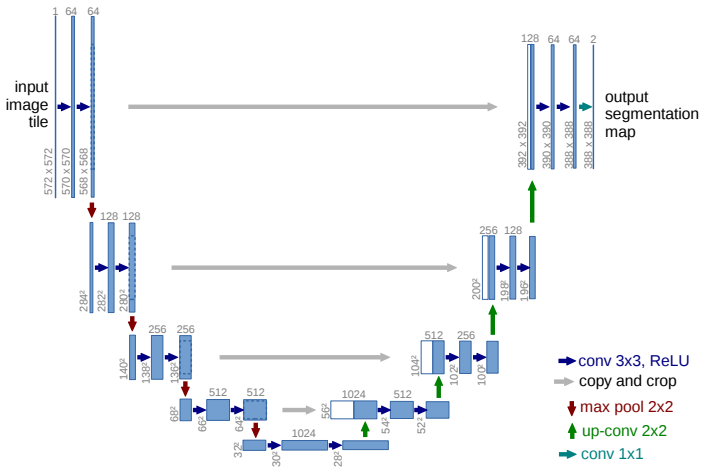

In [30]:
class UNet(nn.Module):
    
    def _conv_conv(self,in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    
    def _enc_layer(self, in_channels, out_channels):
        return nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            self._conv_conv(in_channels, out_channels)
        )
    
    def __init__(self):
        super().__init__()
        
        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.enc_lr0 = self._enc_layer(64, 128)
        self.enc_lr1 = self._enc_layer(128, 256)
        self.enc_lr2 = self._enc_layer(256, 512)
        self.enc_lr3 = self._enc_layer(512, 512)
        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2)#ConvTranspose2d(1024, 512, kernel_size=2, stride=2) # 16 -> 32
        self.dec_conv0 = self._conv_conv(2 * 512, 256)
        self.upsample1 = nn.Upsample(scale_factor=2)#nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv1 = self._conv_conv(2 * 256, 128)
        self.upsample2 = nn.Upsample(scale_factor=2)#nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2) # 64 -> 128
        self.dec_conv2 = self._conv_conv(2 * 128, 64)
        self.upsample3 = nn.Upsample(scale_factor=2)#nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            self._conv_conv(2 * 64, 64),
            nn.Conv2d(64, 1, kernel_size=1),
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_lr0(e0)
        e2 = self.enc_lr1(e1)
        e3 = self.enc_lr2(e2)
        # bottleneck
        b = self.upsample0(self.enc_lr3(e3))

        # decoder
        d0 = self.upsample1(self.dec_conv0(torch.cat((b, e3), dim=1)))
        d1 = self.upsample2(self.dec_conv1(torch.cat((d0, e2), dim=1)))
        d2 = self.upsample3(self.dec_conv2(torch.cat((d1, e1), dim=1)))
        d3 = self.dec_conv3(torch.cat((d2, e0), dim=1))  # no activation
        return d3

In [31]:
# unet = UNet().to(device)
# optim = torch.optim.Adam(unet.parameters(), lr=1e-4)
# loss_func = BCELoss()
# # loss_func = BCELoss_classic()
# #loss_func = FocalTverskyLoss(0.6, 0.4, 2)
# train(unet, optim, loss_func, dataloader_train, dataloader_test)

In [32]:
# score_model(unet, iou_pytorch, dataloader_valid)

A new model by changing the type of pooling:

**Maximum pooling** for downsampling and **Nearest neighbor sampling** for upsampling.
Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Substitute max-pooling with convolutions and stride=2 and upsampling with transpose-convolutions and stride=2.


In [33]:
class UNet2(nn.Module):
    
    def _conv_conv(self,in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    
    def _enc_layer(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=2, padding=1),
            self._conv_conv(in_channels, out_channels)
        )
    
    def __init__(self):
        super().__init__()
        
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.enc_lr0 = self._enc_layer(64, 128)
        self.enc_lr1 = self._enc_layer(128, 256)
        self.enc_lr2 = self._enc_layer(256, 512)
        self.enc_lr3 = self._enc_layer(512, 1024)
        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2) # 16 -> 32
        self.dec_conv0 = self._conv_conv(2 * 512, 512)
        self.upsample1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv1 = self._conv_conv(2 * 256, 256)
        self.upsample2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2) # 64 -> 128
        self.dec_conv2 = self._conv_conv(2 * 128, 128)
        self.upsample3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            self._conv_conv(2 * 64, 64),
            nn.Conv2d(64, 1, kernel_size=1),
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_lr0(e0)
        e2 = self.enc_lr1(e1)
        e3 = self.enc_lr2(e2)
        # bottleneck
        b = self.upsample0(self.enc_lr3(e3))

        # decoder
        d0 = self.upsample1(self.dec_conv0(torch.cat((b, e3), dim=1)))
        d1 = self.upsample2(self.dec_conv1(torch.cat((d0, e2), dim=1)))
        d2 = self.upsample3(self.dec_conv2(torch.cat((d1, e1), dim=1)))
        d3 = self.dec_conv3(torch.cat((d2, e0), dim=1))  # no activation
        return d3

In [36]:
def validate(model, data_tr, data_val, data_ts = None):
  losses = {
      'bce': BCELoss(),
      'lovasz': LovaszLoss(),
      'tversky': TverskyLoss(),
      'dice':DiceLoss()
  }
  loss_keys = losses.keys()

  optimizer = torch.optim.Adam(model.parameters(), lr = 1/50000)
  max_epochs = 40
  model_losses = {}
  model_metric = {}
  model_test = {}
  for loss_fn in loss_keys:
    loss = losses[loss_fn]
    curr_loss, metric = train(model, optimizer, loss, data_tr, data_val)
    model_losses[loss_fn] = curr_loss
    model_metric[loss_fn] = metric
    if data_ts:
      model_test[loss_fn] = [score_model(model, iou_pytorch, data_ts)]
    else:
      model_test[loss_fn] = [score_model(model, iou_pytorch, data_val)]

  return model_losses, model_metric, model_test

# Review: 

In the last of the project I am going to benchmark existing models and identify the best model among proposed via comparing losses and IoU metrics for distinct models and loss functions.

In [37]:
segnet = SegNet().to(device)
unet = UNet().to(device)
unet2 = UNet2().to(device)

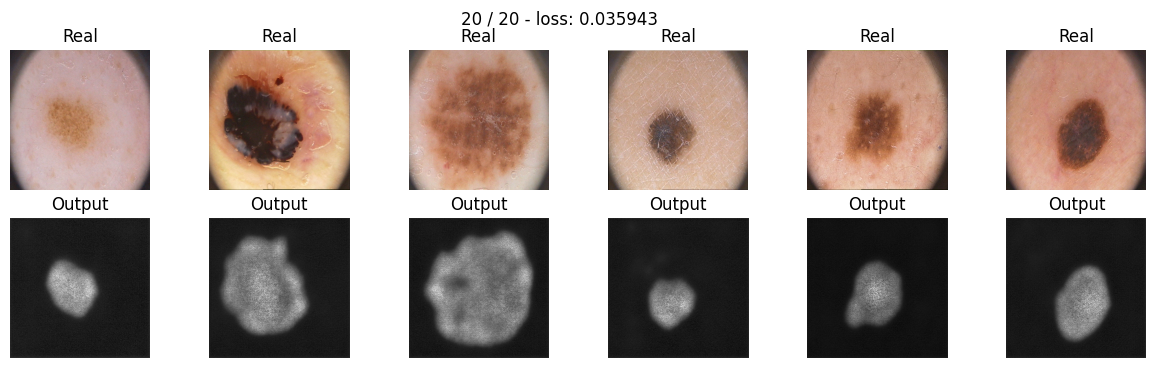

In [38]:
segnet_losses, segnet_metric, segnet_test = validate(segnet, dataloader_train, dataloader_valid)

In [39]:
df_seg_losses = pd.DataFrame(segnet_losses)
df_seg_metric = pd.DataFrame(segnet_metric)
df_seg_test = pd.DataFrame(segnet_test)

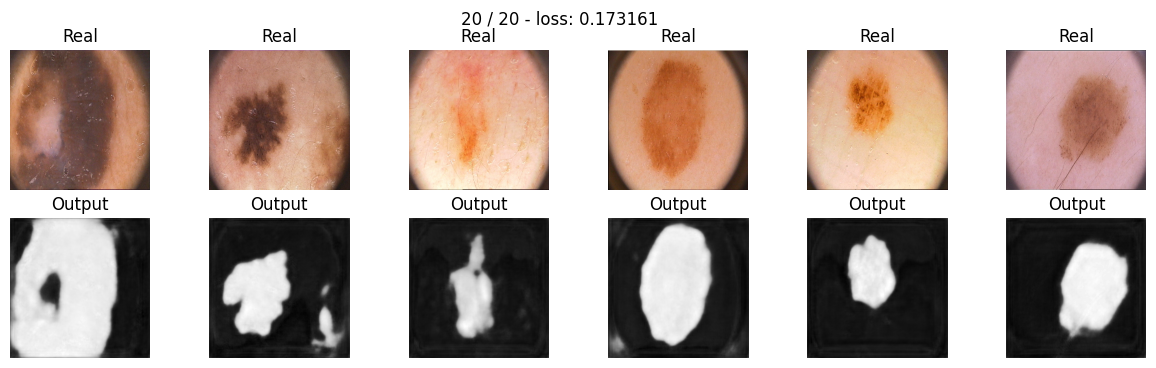

In [40]:
unet_losses, unet_metric, unet_test = validate(unet, dataloader_train, dataloader_valid)

In [41]:
df_u_losses = pd.DataFrame(unet_losses)
df_u_metric = pd.DataFrame(unet_metric)
df_u_test = pd.DataFrame(unet_test)

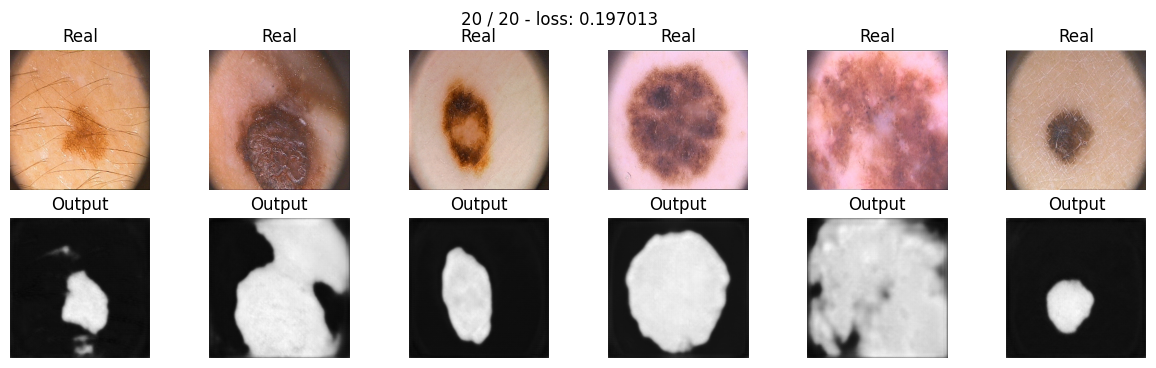

{'bce': [0.40703530609607697, 0.32830020040273666, 0.15356850251555443, 0.1333540678024292, 0.18320227786898613, 0.32700639218091965, 0.3535716384649277, 0.37408973276615143, 0.45057521760463715, 0.5508858934044838, 0.668268546462059, 0.8290380835533142, 0.8110198974609375, 0.847747802734375, 0.7566020637750626, 0.8229382932186127, 0.8982387185096741, 0.8716620802879333, 0.8386562168598175, 0.8493702113628387], 'lovasz': [0.7964223176240921, 0.8332794159650803, 0.6255691647529602, 0.3729979917407036, 0.805719643831253, 0.8345673233270645, 0.8571523278951645, 0.8301081359386444, 0.6686891168355942, 0.8731371462345123, 0.6947814077138901, 0.7770631313323975, 0.8815115243196487, 0.87774658203125, 0.8729085028171539, 0.8648661971092224, 0.8416204452514648, 0.8699704855680466, 0.8800182044506073, 0.8286904245615005], 'tversky': [0.8725736439228058, 0.8937940299510956, 0.8545767664909363, 0.8825191855430603, 0.8980056345462799, 0.8957163691520691, 0.8940644711256027, 0.9000036269426346, 0.88

In [42]:
unet2_losses, unet2_metric, unet2_test = validate(unet2, dataloader_train, dataloader_valid)
print(unet2_metric)

In [43]:
df_u2_losses = pd.DataFrame(unet2_losses)
df_u2_metric = pd.DataFrame(unet2_metric)
df_u2_test = pd.DataFrame(unet2_test)

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

<Figure size 1000x600 with 0 Axes>

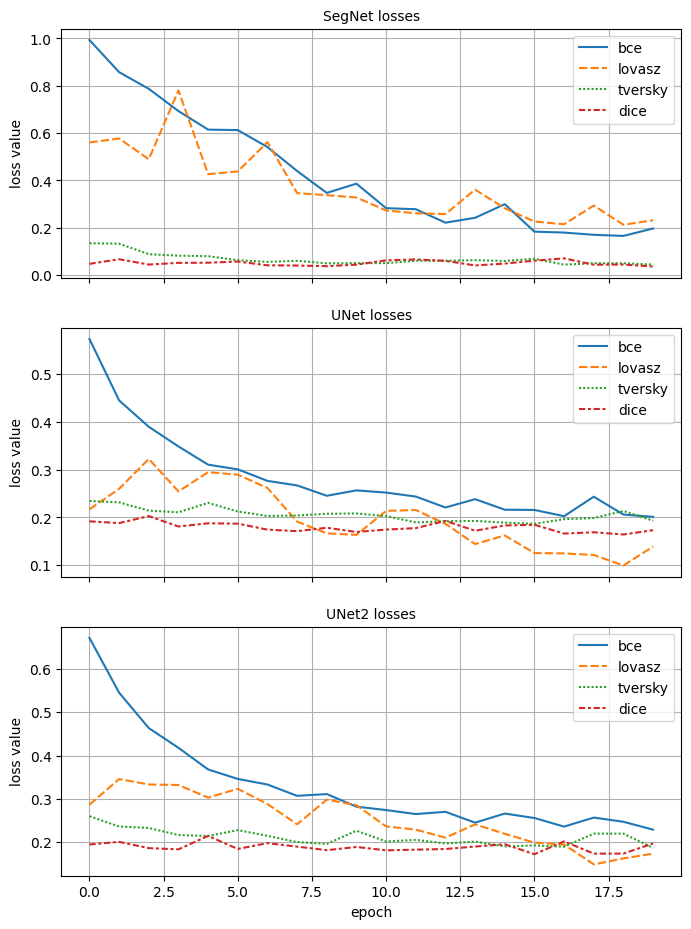

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [168]:
fig, axes = plt.subplots(3, figsize=(8, 11), sharex = True)
plt.figure(figsize=(10, 6))

axes[0].set_title('SegNet losses', size = 10)
sns.lineplot(df_seg_losses, ax = axes[0])
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('loss value')
axes[0].grid(True)

axes[1].set_title("UNet losses", size = 10)
sns.lineplot(df_u_losses,ax = axes[1])
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('loss value')
axes[1].grid(True)

axes[2].set_title("UNet2 losses", size = 10)
sns.lineplot(df_u2_losses, ax = axes[2])
axes[2].set_xlabel('epoch')
axes[2].set_ylabel('loss value')
axes[2].grid(True)

plt.figure(figsize=(10, 6))

From the graphs we see that bce loss converges slower, than any other loss, and generally shows higher loss than any other one.
For any model we see that dice and tversky losses converges the fastest and achieves quite low losses.
Lovasz loss converges faster than bce but lower than dice and tversky. At the same time it shows best results for all models except for SegNet.

Models do not overfit in most cases. However in particular after 17th iteration models trained on lovasz loss starts slighty overfitting, this is seen with the graphs.

<Figure size 1000x600 with 0 Axes>

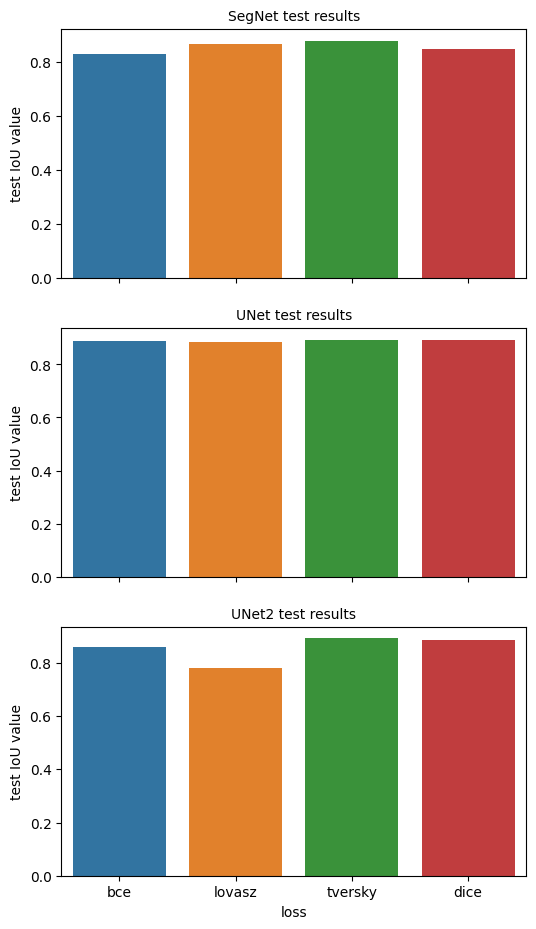

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [173]:
fig, axes = plt.subplots(3, figsize=(6, 11), sharex = True)
plt.figure(figsize=(10, 6))

axes[0].set_title('SegNet test results', size = 10)
sns.barplot(df_seg_test, ax = axes[0])
axes[0].set_ylabel('test IoU value')

axes[1].set_title("UNet test results", size = 10)
sns.barplot(df_u_test, ax = axes[1])
axes[1].set_ylabel('test IoU value')

axes[2].set_title("UNet2 test results", size = 10)
sns.barplot(df_u2_test, ax = axes[2])
axes[2].set_xlabel('loss')
axes[2].set_ylabel('test IoU value')

plt.figure(figsize=(10, 6))

Models show preety results with negligible differences on any loss, however for SegNet Lovasz and Tversky losses demonstrate better metric results. For UNet2 Lovsz show unexpectidly low result relative to other results.

In [119]:
def take_best_loss(losses):
  min_loss = min(losses.tail(1).values[0])
  for col in losses.columns:
    if losses[col].tail(1).values == min_loss:
      best_loss = losses[col]
      break
  return best_loss, col

def take_best_test(tests):
  best_test = max(tests.tail(1).values[0])
  for col in tests.columns:
    if tests[col].tail(1).values == best_test:
      best_loss = tests[col]
      break
  return best_test, col

In [204]:
best_losses = {
    'SegNet': take_best_loss(df_seg_losses),
    'UNet': take_best_loss(df_u_losses),
    'UNet2': take_best_loss(df_u2_losses)
}

best_test = {
    'SegNet': take_best_test(df_seg_test),
    'UNet': take_best_test(df_u_test),
    'UNet2': take_best_test(df_u2_test)
}
df_best_test = pd.DataFrame(best_test).loc[:0]
df_best_test = df_best_test.rename(columns={
    'SegNet': 'SegNet: '+take_best_test(df_seg_test)[1],
    'UNet': 'UNet: '+take_best_test(df_u_test)[1],
    'UNet2': 'UNet2: '+take_best_test(df_u2_test)[1]
     })


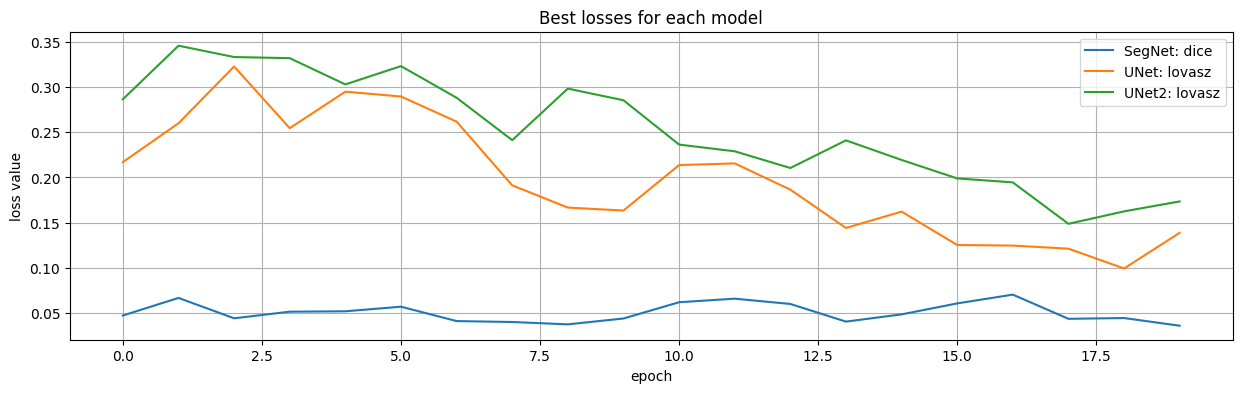

In [161]:
plt.plot(best_losses['SegNet'][0])
plt.plot(best_losses['UNet'][0])
plt.plot(best_losses['UNet2'][0])
plt.title('Best losses for each model')
plt.xlabel('epoch')
plt.ylabel('loss value')
plt.legend(['SegNet: ' + best_losses['SegNet'][1],
            'UNet: ' + best_losses['UNet'][1],
            'UNet2: ' + best_losses['UNet2'][1]])
plt.grid()

<Axes: >

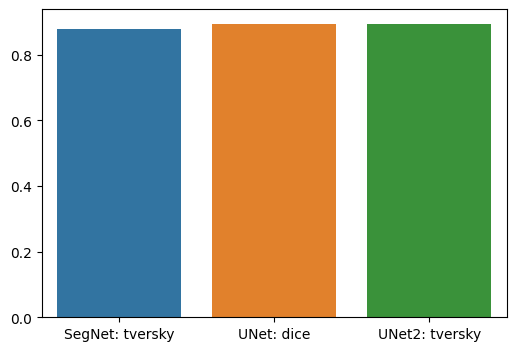

In [206]:
plt.figure(figsize = (6, 4))
sns.barplot(df_best_test)

Finally, we can observe best losses and test results for each model. On graph of losses we can see that results for each model vary significantly. Whereas results for test metric are similar, however SegNet results are lower that results of UNet and UNet2.

To conclude, SegNet shows best loss score on dice loss, while UNet shows the best IoU score on dice loss.
